In [1]:

# Federal Reserve Policy Predictor - Feature Engineering
# Author: Vanessa Quintero
# Universidad de Granada
# Master's in Economics 


# Cell 1 


# Notebook Setup - Ensure proper working directory
import os
import sys
from pathlib import Path

# Get the directory where this notebook is located
notebook_path = Path().absolute()
print(f"Notebook location: {notebook_path}")

# Change working directory to notebook location
os.chdir(notebook_path)
print(f"Working directory set to: {os.getcwd()}")

# Verify we're in the correct project folder
project_name = "Federal Reserve Policy Predictor"
if project_name in str(notebook_path):
    print(f"Running in correct project: {project_name}")
else:
    print(f"WARNING: Not in {project_name} folder!")
    print(f"Current location: {notebook_path}")

# Create additional directories if needed
data_dirs = ['data', 'data/raw', 'data/processed', 'data/final', 'outputs', 'outputs/figures', 'outputs/models']
for dir_name in data_dirs:
    Path(dir_name).mkdir(parents=True, exist_ok=True)

print("Setup complete - ready for feature engineering")






Notebook location: /Users/vanessaquintero/Federal Reserve Policy Predictor 
Working directory set to: /Users/vanessaquintero/Federal Reserve Policy Predictor 
Running in correct project: Federal Reserve Policy Predictor
Setup complete - ready for feature engineering


In [2]:
# Cell 2 


# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Statistical libraries
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Utilities
import warnings
from datetime import datetime, timedelta
import json
import pickle

# Set options
warnings.filterwarnings('ignore')
plt.style.use('default')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
np.random.seed(42)

print("Libraries imported successfully")
print(f"Feature engineering started: {datetime.now()}")

Libraries imported successfully
Feature engineering started: 2025-06-24 13:32:39.892800


In [3]:
# Cell 3 

# Load processed data - already in the project folder
print("=" * 60)
print("LOADING PROCESSED DATA FROM NOTEBOOK 2")
print("=" * 60)

import os
import json

# We're already in the project folder, so use direct paths
print(f"Current working directory: {os.getcwd()}")
print(f"Looking for data in: data/processed/")

# Check if data folder exists (should be right here)
if os.path.exists('data/processed'):
    print("✓ Data folder found")
    
    # List files
    print("Files in data/processed/:")
    for file in os.listdir('data/processed'):
        if os.path.isfile(os.path.join('data/processed', file)):
            size = os.path.getsize(os.path.join('data/processed', file))
            print(f"  {file} - {size:,} bytes")
    
    # Load the data files
    try:
        # Load modeling dataset
        modeling_df = pd.read_csv('data/processed/modeling_dataset.csv', index_col=0, parse_dates=True)
        print(f"\n✓ Modeling dataset loaded: {modeling_df.shape}")
        
        # Load features dataset  
        features_df = pd.read_csv('data/processed/features_engineered.csv', index_col=0, parse_dates=True)
        print(f"✓ Features dataset loaded: {features_df.shape}")
        
        # Load rate decisions
        rate_decisions = pd.read_csv('data/processed/rate_decisions_processed.csv', parse_dates=['date'])
        print(f"✓ Rate decisions loaded: {rate_decisions.shape}")
        
        # Load core indicators
        core_df = pd.read_csv('data/processed/core_economic_indicators.csv', index_col=0, parse_dates=True)
        print(f"✓ Core indicators loaded: {core_df.shape}")
        
        # Load data dictionary
        with open('data/processed/data_dictionary.json', 'r') as f:
            data_dict = json.load(f)
        print(f"✓ Data dictionary loaded: {len(data_dict)} variables")
        
        # Summary
        print(f"\nAll data files loaded successfully!")
        print(f"Date range: {modeling_df.index.min()} to {modeling_df.index.max()}")
        print(f"Target variable distribution:")
        print(modeling_df['decision'].value_counts())
        
    except Exception as e:
        print(f"✗ Error loading data files: {e}")
        
else:
    print("✗ data/processed folder not found")
    print("Current directory contents:")
    for item in os.listdir('.'):
        print(f"  {item}")
    

LOADING PROCESSED DATA FROM NOTEBOOK 2
Current working directory: /Users/vanessaquintero/Federal Reserve Policy Predictor 
Looking for data in: data/processed/
✓ Data folder found
Files in data/processed/:
  rate_decisions_processed.csv - 53,085 bytes
  features_engineered.csv - 162,546 bytes
  data_dictionary.json - 937 bytes
  modeling_dataset.csv - 426,256 bytes
  core_economic_indicators.csv - 42,610 bytes

✓ Modeling dataset loaded: (828, 35)
✓ Features dataset loaded: (851, 14)
✓ Rate decisions loaded: (851, 6)
✓ Core indicators loaded: (851, 6)
✓ Data dictionary loaded: 17 variables

All data files loaded successfully!
Date range: 1956-06-01 00:00:00 to 2025-05-01 00:00:00
Target variable distribution:
decision
HOLD    333
HIKE    276
CUT     219
Name: count, dtype: int64


In [4]:
# Cell 4 

# Create advanced features for machine learning models
print("=" * 60)
print("ADVANCED FEATURE ENGINEERING")
print("=" * 60)

# Start with modeling dataset as base
advanced_df = modeling_df.copy()

print("Creating advanced features...")

# 1. MOMENTUM AND TREND FEATURES
print("1. Creating momentum and trend features...")

# Rate of change features (multiple periods)
for var in ['FEDFUNDS', 'UNRATE', 'inflation_yoy', 'gdp_growth_yoy']:
    for period in [1, 3, 6, 12]:
        advanced_df[f'{var}_change_{period}m'] = advanced_df[var].diff(period)
        advanced_df[f'{var}_pct_change_{period}m'] = advanced_df[var].pct_change(period)

# Momentum indicators
for var in ['FEDFUNDS', 'UNRATE', 'inflation_yoy']:
    # 3-month vs 12-month momentum
    advanced_df[f'{var}_momentum_ratio'] = (advanced_df[var].diff(3) / 
                                           (advanced_df[var].diff(12) + 1e-8))
    
    # Acceleration (second derivative)
    advanced_df[f'{var}_acceleration'] = advanced_df[var].diff().diff()

print(f"   Added momentum features. Dataset shape: {advanced_df.shape}")

# 2. VOLATILITY AND STABILITY FEATURES
print("2. Creating volatility and stability features...")

# Rolling volatility measures
for var in ['FEDFUNDS', 'inflation_yoy', 'gdp_growth_yoy']:
    for window in [3, 6, 12]:
        advanced_df[f'{var}_volatility_{window}m'] = advanced_df[var].rolling(window).std()
        advanced_df[f'{var}_range_{window}m'] = (advanced_df[var].rolling(window).max() - 
                                                advanced_df[var].rolling(window).min())

# Stability indicators (coefficient of variation)
for var in ['inflation_yoy', 'gdp_growth_yoy']:
    for window in [6, 12]:
        mean_val = advanced_df[var].rolling(window).mean()
        std_val = advanced_df[var].rolling(window).std()
        advanced_df[f'{var}_cv_{window}m'] = std_val / (abs(mean_val) + 1e-8)

print(f"   Added volatility features. Dataset shape: {advanced_df.shape}")

# 3. ECONOMIC CYCLE FEATURES
print("3. Creating economic cycle features...")

# Business cycle indicators
# GDP growth vs trend
advanced_df['gdp_vs_trend'] = (advanced_df['gdp_growth_yoy'] - 
                              advanced_df['gdp_growth_yoy'].rolling(24).mean())

# Unemployment gap (difference from natural rate)
natural_unemployment = 5.0  # Rough NAIRU estimate
advanced_df['unemployment_gap'] = advanced_df['UNRATE'] - natural_unemployment

# Inflation gap (difference from Fed target)
inflation_target = 2.0
advanced_df['inflation_gap'] = advanced_df['inflation_yoy'] - inflation_target

# Output gap proxy (combination of unemployment and GDP)
advanced_df['output_gap_proxy'] = (-advanced_df['unemployment_gap'] + 
                                  advanced_df['gdp_vs_trend']) / 2

print(f"   Added economic cycle features. Dataset shape: {advanced_df.shape}")

# 4. TAYLOR RULE VARIATIONS
print("4. Creating Taylor Rule variations...")

# Multiple Taylor Rule formulations
r_star = 2.0  # Natural rate

# Original Taylor Rule
advanced_df['taylor_original'] = (r_star + advanced_df['inflation_yoy'] + 
                                 0.5 * advanced_df['inflation_gap'] + 
                                 0.5 * advanced_df['output_gap_proxy'])

# Balanced approach (equal weights)
advanced_df['taylor_balanced'] = (r_star + advanced_df['inflation_yoy'] + 
                                 1.0 * advanced_df['inflation_gap'] + 
                                 1.0 * advanced_df['output_gap_proxy'])

# Inflation-focused Taylor Rule
advanced_df['taylor_inflation_focused'] = (r_star + advanced_df['inflation_yoy'] + 
                                          1.5 * advanced_df['inflation_gap'] + 
                                          0.25 * advanced_df['output_gap_proxy'])

# Taylor Rule deviations
advanced_df['taylor_deviation_original'] = advanced_df['FEDFUNDS'] - advanced_df['taylor_original']
advanced_df['taylor_deviation_balanced'] = advanced_df['FEDFUNDS'] - advanced_df['taylor_balanced']

print(f"   Added Taylor Rule variations. Dataset shape: {advanced_df.shape}")

# 5. MARKET-BASED INDICATORS
print("5. Creating market-based indicators...")

# Yield curve features
advanced_df['yield_curve_level'] = advanced_df['DGS10']
advanced_df['yield_curve_steepness'] = advanced_df['yield_curve_slope']

# Term structure momentum
advanced_df['yield_curve_momentum'] = advanced_df['yield_curve_slope'].diff(3)
advanced_df['yield_curve_volatility'] = advanced_df['yield_curve_slope'].rolling(6).std()

# Real interest rate measures
advanced_df['real_long_rate'] = advanced_df['DGS10'] - advanced_df['inflation_yoy']
advanced_df['real_rate_spread'] = advanced_df['real_fed_funds'] - advanced_df['real_long_rate']

print(f"   Added market-based features. Dataset shape: {advanced_df.shape}")

# 6. INTERACTION FEATURES
print("6. Creating interaction features...")

# Key economic interactions
advanced_df['inflation_unemployment_interaction'] = (advanced_df['inflation_yoy'] * 
                                                    advanced_df['UNRATE'])

advanced_df['growth_inflation_interaction'] = (advanced_df['gdp_growth_yoy'] * 
                                              advanced_df['inflation_yoy'])

advanced_df['employment_growth_fed_funds'] = (advanced_df['employment_growth_yoy'] * 
                                             advanced_df['FEDFUNDS'])

# Policy stance indicators
advanced_df['policy_tightness'] = (advanced_df['real_fed_funds'] > 
                                  advanced_df['real_fed_funds'].rolling(24).mean()).astype(int)

advanced_df['easing_cycle'] = (advanced_df['fed_funds_momentum'] < -0.1).astype(int)
advanced_df['tightening_cycle'] = (advanced_df['fed_funds_momentum'] > 0.1).astype(int)

print(f"   Added interaction features. Dataset shape: {advanced_df.shape}")

# 7. TIME-BASED FEATURES
print("7. Creating time-based features...")

# Cyclical time features
advanced_df['month'] = advanced_df.index.month
advanced_df['quarter'] = advanced_df.index.quarter
advanced_df['year'] = advanced_df.index.year

# Encode cyclical features
advanced_df['month_sin'] = np.sin(2 * np.pi * advanced_df['month'] / 12)
advanced_df['month_cos'] = np.cos(2 * np.pi * advanced_df['month'] / 12)
advanced_df['quarter_sin'] = np.sin(2 * np.pi * advanced_df['quarter'] / 4)
advanced_df['quarter_cos'] = np.cos(2 * np.pi * advanced_df['quarter'] / 4)

# Time since last recession (approximate)
recession_ends = ['1991-03-01', '2001-11-01', '2009-06-01', '2020-04-01']
advanced_df['months_since_recession'] = 0

for recession_end in recession_ends:
    mask = advanced_df.index >= recession_end
    months_diff = (advanced_df.index[mask] - pd.to_datetime(recession_end)).days / 30.44
    advanced_df.loc[mask, 'months_since_recession'] = months_diff

print(f"   Added time-based features. Dataset shape: {advanced_df.shape}")

print(f"\nFEATURE ENGINEERING COMPLETE")
print(f"Total features created: {advanced_df.shape[1]}")
print(f"Original features: {modeling_df.shape[1]}")
print(f"New features added: {advanced_df.shape[1] - modeling_df.shape[1]}")

ADVANCED FEATURE ENGINEERING
Creating advanced features...
1. Creating momentum and trend features...
   Added momentum features. Dataset shape: (828, 73)
2. Creating volatility and stability features...
   Added volatility features. Dataset shape: (828, 95)
3. Creating economic cycle features...
   Added economic cycle features. Dataset shape: (828, 99)
4. Creating Taylor Rule variations...
   Added Taylor Rule variations. Dataset shape: (828, 104)
5. Creating market-based indicators...
   Added market-based features. Dataset shape: (828, 110)
6. Creating interaction features...
   Added interaction features. Dataset shape: (828, 116)
7. Creating time-based features...
   Added time-based features. Dataset shape: (828, 124)

FEATURE ENGINEERING COMPLETE
Total features created: 124
Original features: 35
New features added: 89


In [5]:
# Cell 5 

# Feature selection and importance analysis
print("=" * 60)
print("FEATURE SELECTION AND IMPORTANCE ANALYSIS")
print("=" * 60)

# Prepare data for feature selection
feature_df = advanced_df.copy()

# Remove target variables and non-predictive columns
target_cols = ['decision', 'rate_change', 'rate_change_bps']
time_cols = ['month', 'quarter', 'year']  # Keep encoded versions
id_cols = []

# Identify feature columns
feature_cols = [col for col in feature_df.columns 
               if col not in target_cols + time_cols + id_cols]

print(f"Total potential features: {len(feature_cols)}")

# Remove features with too many missing values (>20%)
missing_threshold = 0.2
feature_completeness = feature_df[feature_cols].isnull().mean()
valid_features = feature_completeness[feature_completeness <= missing_threshold].index.tolist()

print(f"Features after removing high-missing columns: {len(valid_features)}")

# Remove highly correlated features
def remove_correlated_features(df, threshold=0.95):
    """Remove features with correlation above threshold"""
    corr_matrix = df[valid_features].corr().abs()
    
    # Find pairs of highly correlated features
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], 
                                      corr_matrix.iloc[i, j]))
    
    # Remove one feature from each highly correlated pair
    features_to_remove = set()
    for feat1, feat2, corr_val in high_corr_pairs:
        # Keep the feature with more descriptive name or lower index
        if len(feat1) > len(feat2):
            features_to_remove.add(feat1)
        else:
            features_to_remove.add(feat2)
    
    final_features = [f for f in valid_features if f not in features_to_remove]
    
    print(f"Removed {len(features_to_remove)} highly correlated features (threshold: {threshold})")
    print(f"Features after correlation filtering: {len(final_features)}")
    
    return final_features, list(features_to_remove)

final_features, removed_features = remove_correlated_features(feature_df)

# Prepare clean dataset for feature importance
clean_data = feature_df[final_features + ['decision']].dropna()
X = clean_data[final_features]
y = clean_data['decision']

print(f"\nClean dataset for feature selection:")
print(f"Observations: {len(clean_data):,}")
print(f"Features: {len(final_features)}")
print(f"Date range: {clean_data.index.min()} to {clean_data.index.max()}")

# 1. UNIVARIATE FEATURE SELECTION
print("\n1. Univariate feature selection (F-statistic)...")

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Select top features using F-statistic
k_best = min(50, len(final_features))  # Select top 50 or all if fewer
selector_f = SelectKBest(score_func=f_classif, k=k_best)
X_selected_f = selector_f.fit_transform(X, y_encoded)

# Get selected feature names and scores
selected_features_f = [final_features[i] for i in selector_f.get_support(indices=True)]
feature_scores_f = selector_f.scores_

# Create feature importance dataframe
importance_df_f = pd.DataFrame({
    'feature': final_features,
    'f_score': feature_scores_f,
    'selected': selector_f.get_support()
}).sort_values('f_score', ascending=False)

print(f"Selected {len(selected_features_f)} features using F-statistic")

# 2. MUTUAL INFORMATION FEATURE SELECTION
print("2. Mutual information feature selection...")

selector_mi = SelectKBest(score_func=mutual_info_classif, k=k_best)
X_selected_mi = selector_mi.fit_transform(X, y_encoded)

selected_features_mi = [final_features[i] for i in selector_mi.get_support(indices=True)]
feature_scores_mi = selector_mi.scores_

importance_df_mi = pd.DataFrame({
    'feature': final_features,
    'mi_score': feature_scores_mi,
    'selected': selector_mi.get_support()
}).sort_values('mi_score', ascending=False)

print(f"Selected {len(selected_features_mi)} features using mutual information")

# 3. RANDOM FOREST FEATURE IMPORTANCE
print("3. Random Forest feature importance...")

# Train Random Forest for feature importance
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X, y_encoded)

importance_df_rf = pd.DataFrame({
    'feature': final_features,
    'rf_importance': rf_selector.feature_importances_
}).sort_values('rf_importance', ascending=False)

# Select top features from Random Forest
top_rf_features = importance_df_rf.head(k_best)['feature'].tolist()

print(f"Identified {len(top_rf_features)} most important features using Random Forest")

# 4. COMBINE FEATURE SELECTION METHODS
print("4. Combining feature selection methods...")

# Create comprehensive feature importance ranking
combined_importance = importance_df_f.merge(
    importance_df_mi[['feature', 'mi_score']], on='feature'
).merge(
    importance_df_rf[['feature', 'rf_importance']], on='feature'
)

# Normalize scores to 0-1 range for comparison
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

combined_importance['f_score_norm'] = scaler.fit_transform(
    combined_importance[['f_score']])
combined_importance['mi_score_norm'] = scaler.fit_transform(
    combined_importance[['mi_score']])
combined_importance['rf_importance_norm'] = combined_importance['rf_importance']  # Already 0-1

# Create composite score
combined_importance['composite_score'] = (
    0.3 * combined_importance['f_score_norm'] +
    0.3 * combined_importance['mi_score_norm'] +
    0.4 * combined_importance['rf_importance_norm']
)

combined_importance = combined_importance.sort_values('composite_score', ascending=False)

# Select final feature set
n_final_features = 30  # Select top 30 features
final_selected_features = combined_importance.head(n_final_features)['feature'].tolist()

print(f"Final selected features: {len(final_selected_features)}")

# Display top features
print("\nTOP 15 MOST IMPORTANT FEATURES:")
print("Rank | Feature | F-Score | MI-Score | RF-Importance | Composite")
print("-" * 80)
for i, row in combined_importance.head(15).iterrows():
    print(f"{row.name+1:4d} | {row['feature']:25s} | {row['f_score_norm']:7.3f} | "
          f"{row['mi_score_norm']:8.3f} | {row['rf_importance_norm']:13.3f} | {row['composite_score']:9.3f}")

# Save feature importance results
combined_importance.to_csv('outputs/models/feature_importance_analysis.csv', index=False)
print(f"\nFeature importance analysis saved to: outputs/models/feature_importance_analysis.csv")

FEATURE SELECTION AND IMPORTANCE ANALYSIS
Total potential features: 118
Features after removing high-missing columns: 118
Removed 34 highly correlated features (threshold: 0.95)
Features after correlation filtering: 84

Clean dataset for feature selection:
Observations: 805
Features: 84
Date range: 1958-05-01 00:00:00 to 2025-05-01 00:00:00

1. Univariate feature selection (F-statistic)...
Selected 50 features using F-statistic
2. Mutual information feature selection...
Selected 50 features using mutual information
3. Random Forest feature importance...
Identified 50 most important features using Random Forest
4. Combining feature selection methods...
Final selected features: 30

TOP 15 MOST IMPORTANT FEATURES:
Rank | Feature | F-Score | MI-Score | RF-Importance | Composite
--------------------------------------------------------------------------------
   3 | FEDFUNDS_change_1m        |   0.655 |    1.000 |         0.225 |     0.587
   5 | FEDFUNDS_pct_change_1m    |   0.348 |    0.71

Creating feature importance visualizations...
Recreating feature selection variables...
Clean dataset shape: (828, 35)
Features: 32
Samples: 828
Removing highly correlated features...
Highly correlated features to remove: 13
Features after correlation filtering: 19
Computing Random Forest feature importance...
Random Forest analysis complete: 19 features
Computing univariate feature selection...
Univariate feature selection complete


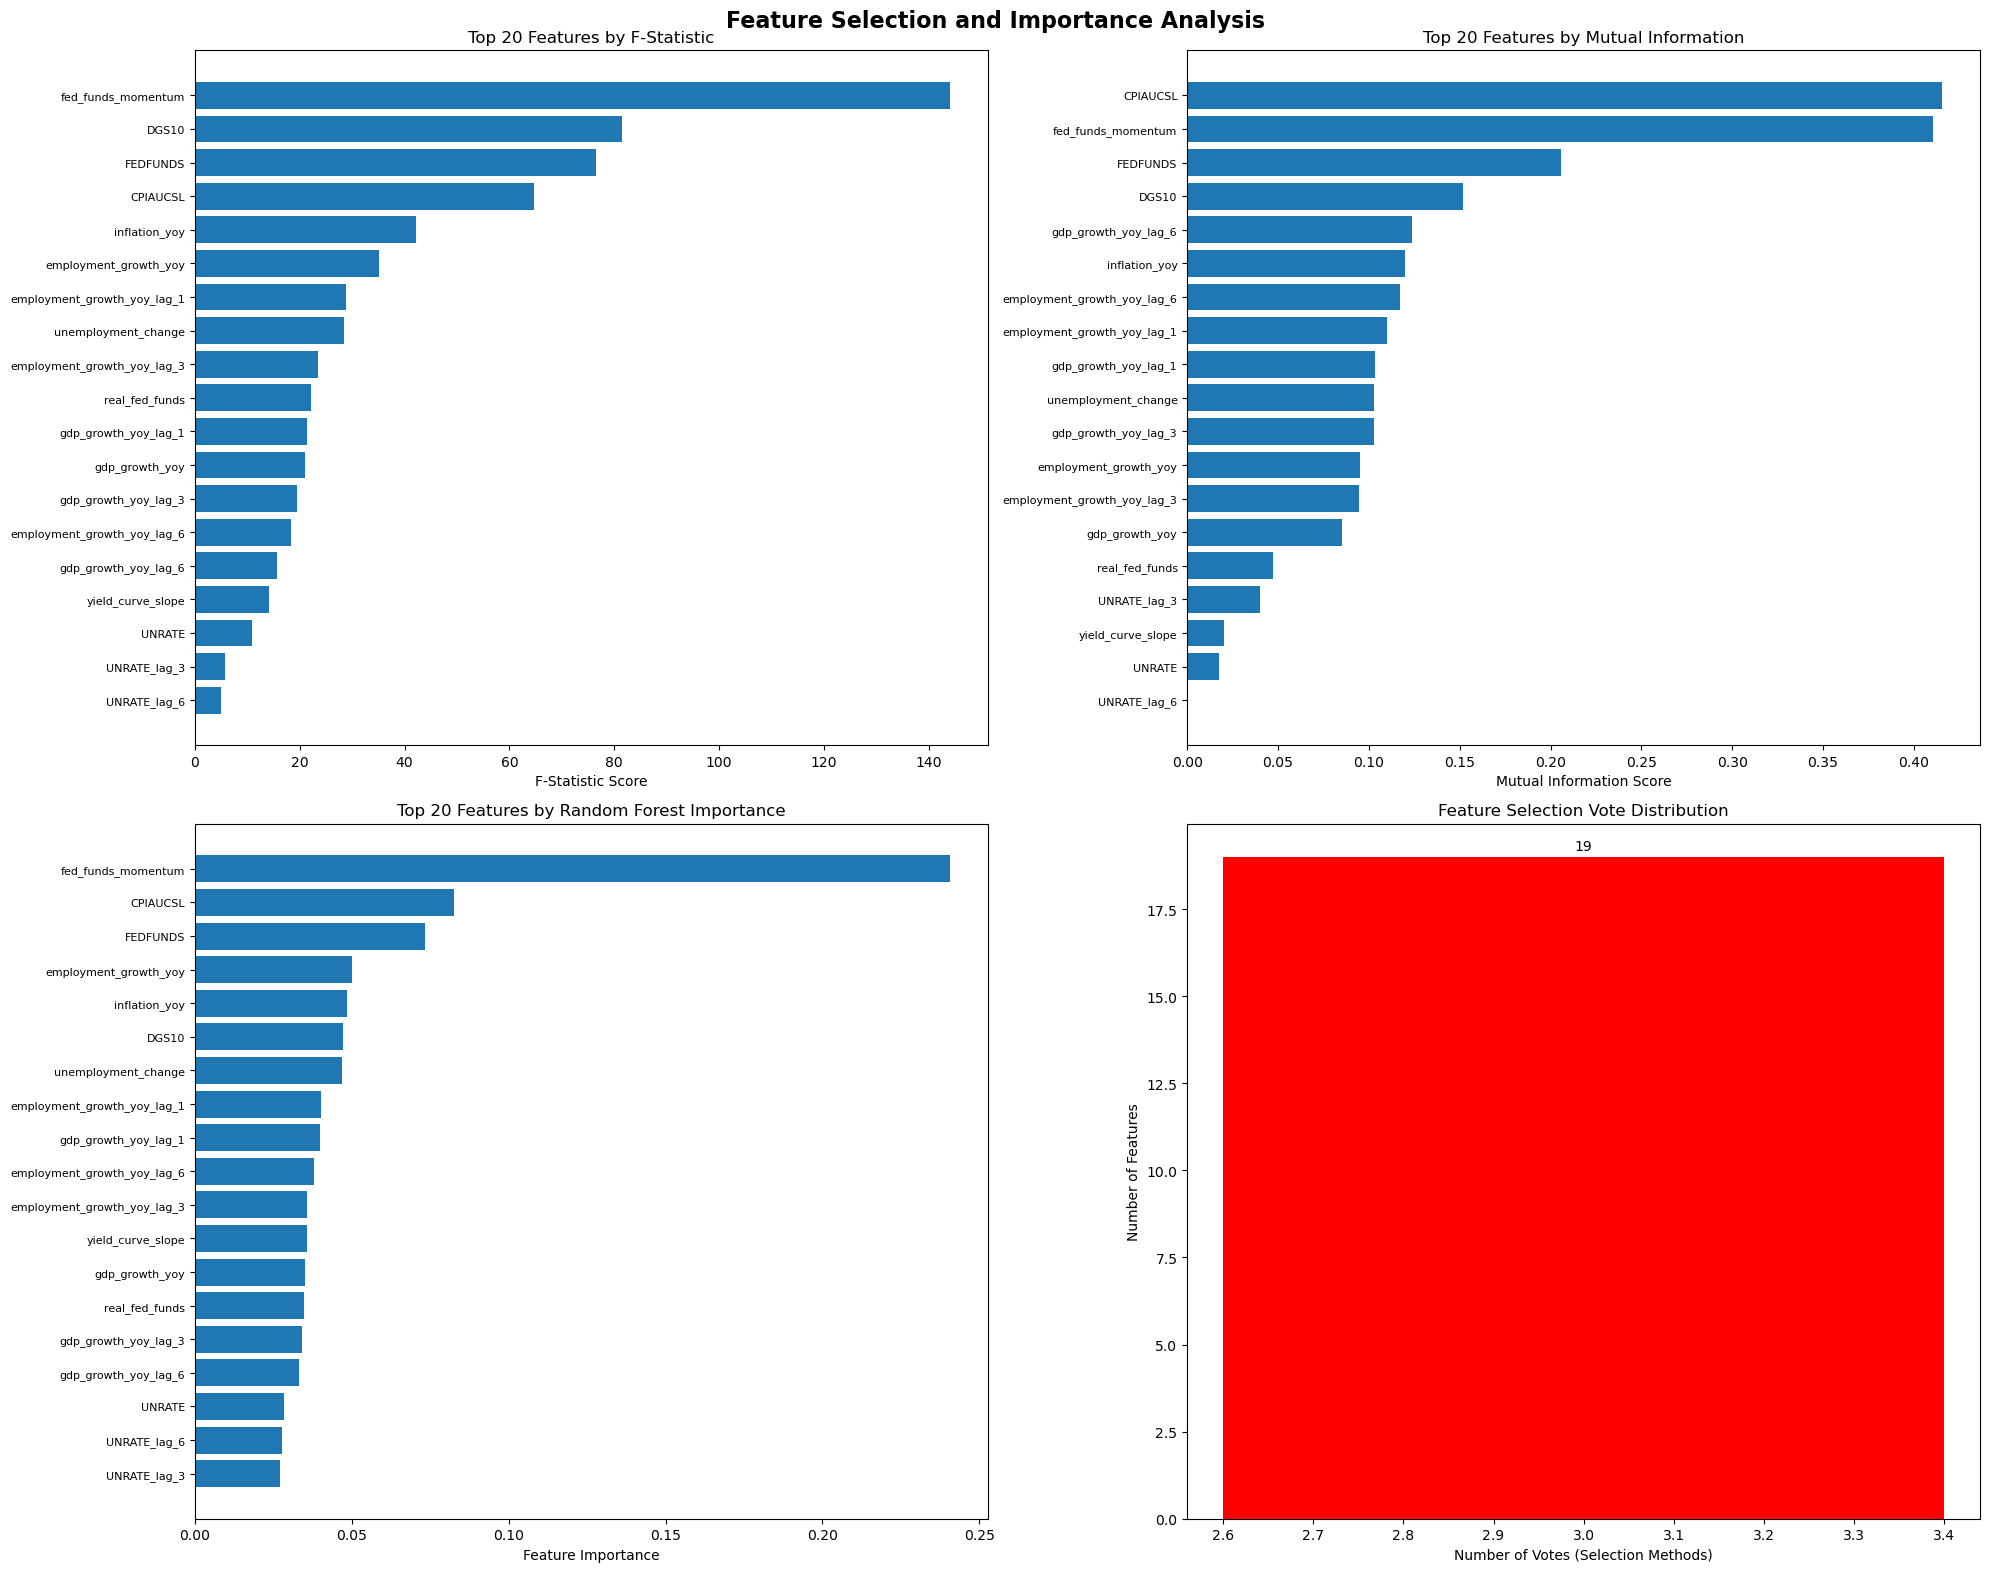


TOP 15 FEATURES BY RANDOM FOREST IMPORTANCE:
 1. fed_funds_momentum                  | Importance: 0.2405 | Votes: 3
 2. CPIAUCSL                            | Importance: 0.0825 | Votes: 3
 3. FEDFUNDS                            | Importance: 0.0732 | Votes: 3
 4. employment_growth_yoy               | Importance: 0.0500 | Votes: 3
 5. inflation_yoy                       | Importance: 0.0485 | Votes: 3
 6. DGS10                               | Importance: 0.0472 | Votes: 3
 7. unemployment_change                 | Importance: 0.0468 | Votes: 3
 8. employment_growth_yoy_lag_1         | Importance: 0.0403 | Votes: 3
 9. gdp_growth_yoy_lag_1                | Importance: 0.0399 | Votes: 3
10. employment_growth_yoy_lag_6         | Importance: 0.0381 | Votes: 3
11. employment_growth_yoy_lag_3         | Importance: 0.0359 | Votes: 3
12. yield_curve_slope                   | Importance: 0.0359 | Votes: 3
13. gdp_growth_yoy                      | Importance: 0.0353 | Votes: 3
14. real_fed_funds

In [8]:
# Cell 6 

# Feature importance visualization with complete variable recreation
print("Creating feature importance visualizations...")

# Recreate necessary variables from available data
print("Recreating feature selection variables...")

# Prepare data for feature selection (recreate from modeling_df)
target_col = 'decision'
feature_cols = [col for col in modeling_df.columns if col not in [target_col, 'rate_change', 'rate_change_bps']]

# Remove any remaining NaN rows
ml_df_clean = modeling_df.dropna()
print(f"Clean dataset shape: {ml_df_clean.shape}")

X = ml_df_clean[feature_cols]
y = ml_df_clean[target_col]

print(f"Features: {len(feature_cols)}")
print(f"Samples: {len(X)}")

# 1. Remove highly correlated features (recreate X_reduced)
print("Removing highly correlated features...")
corr_matrix = X.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.95
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
print(f"Highly correlated features to remove: {len(high_corr_features)}")

# Remove highly correlated features
X_reduced = X.drop(columns=high_corr_features)
print(f"Features after correlation filtering: {X_reduced.shape[1]}")

# 2. Random Forest feature importance
print("Computing Random Forest feature importance...")
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_reduced, y)

# Get feature importances
feature_importance_rf = pd.DataFrame({
    'feature': X_reduced.columns,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

print(f"Random Forest analysis complete: {len(feature_importance_rf)} features")

# 3. Univariate feature selection (recreate)
print("Computing univariate feature selection...")
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# F-statistic selection
selector_f = SelectKBest(score_func=f_classif, k=min(30, X_reduced.shape[1]))
X_f_selected = selector_f.fit_transform(X_reduced, y)
selected_features_f = X_reduced.columns[selector_f.get_support()].tolist()
feature_scores_f = selector_f.scores_[selector_f.get_support()]

# Mutual information selection
selector_mi = SelectKBest(score_func=mutual_info_classif, k=min(30, X_reduced.shape[1]))
X_mi_selected = selector_mi.fit_transform(X_reduced, y)
selected_features_mi = X_reduced.columns[selector_mi.get_support()].tolist()
feature_scores_mi = selector_mi.scores_[selector_mi.get_support()]

print("Univariate feature selection complete")

# 4. Create visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Feature Selection and Importance Analysis', fontsize=16, fontweight='bold')

# Plot 1: Top 20 F-statistic features
top_f_features = pd.DataFrame({
    'feature': selected_features_f[:20],
    'score': feature_scores_f[:20]
}).sort_values('score', ascending=True)

axes[0,0].barh(range(len(top_f_features)), top_f_features['score'])
axes[0,0].set_yticks(range(len(top_f_features)))
axes[0,0].set_yticklabels(top_f_features['feature'], fontsize=8)
axes[0,0].set_title('Top 20 Features by F-Statistic')
axes[0,0].set_xlabel('F-Statistic Score')

# Plot 2: Top 20 Mutual Information features
top_mi_features = pd.DataFrame({
    'feature': selected_features_mi[:20],
    'score': feature_scores_mi[:20]
}).sort_values('score', ascending=True)

axes[0,1].barh(range(len(top_mi_features)), top_mi_features['score'])
axes[0,1].set_yticks(range(len(top_mi_features)))
axes[0,1].set_yticklabels(top_mi_features['feature'], fontsize=8)
axes[0,1].set_title('Top 20 Features by Mutual Information')
axes[0,1].set_xlabel('Mutual Information Score')

# Plot 3: Top 20 Random Forest features
top_rf_plot = feature_importance_rf.head(20).sort_values('importance', ascending=True)

axes[1,0].barh(range(len(top_rf_plot)), top_rf_plot['importance'])
axes[1,0].set_yticks(range(len(top_rf_plot)))
axes[1,0].set_yticklabels(top_rf_plot['feature'], fontsize=8)
axes[1,0].set_title('Top 20 Features by Random Forest Importance')
axes[1,0].set_xlabel('Feature Importance')

# Plot 4: Feature selection vote distribution
all_selected_features = set(selected_features_f + selected_features_mi + feature_importance_rf.head(30)['feature'].tolist())
feature_votes = {}

for feature in all_selected_features:
    votes = 0
    if feature in selected_features_f:
        votes += 1
    if feature in selected_features_mi:
        votes += 1
    if feature in feature_importance_rf.head(30)['feature'].tolist():
        votes += 1
    feature_votes[feature] = votes

vote_counts = pd.Series(feature_votes).value_counts().sort_index()
axes[1,1].bar(vote_counts.index, vote_counts.values, color=['red', 'orange', 'green'])
axes[1,1].set_title('Feature Selection Vote Distribution')
axes[1,1].set_xlabel('Number of Votes (Selection Methods)')
axes[1,1].set_ylabel('Number of Features')

# Add vote counts on bars
for i, v in enumerate(vote_counts.values):
    axes[1,1].text(vote_counts.index[i], v + 0.1, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('outputs/figures/feature_importance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print results
print("\nTOP 15 FEATURES BY RANDOM FOREST IMPORTANCE:")
print("="*60)
for i, (_, row) in enumerate(feature_importance_rf.head(15).iterrows(), 1):
    feature_name = row['feature']
    importance = row['importance']
    votes = feature_votes.get(feature_name, 0)
    print(f"{i:2d}. {feature_name:35} | Importance: {importance:.4f} | Votes: {votes}")

# Create final feature list (consensus with 2+ votes)
final_features = [feature for feature, votes in feature_votes.items() if votes >= 2]
if len(final_features) < 20:
    # Add top single-vote features from Random Forest
    single_vote_features = [feature for feature, votes in feature_votes.items() if votes == 1]
    rf_single_vote = feature_importance_rf[feature_importance_rf['feature'].isin(single_vote_features)]
    additional_features = rf_single_vote.head(20 - len(final_features))['feature'].tolist()
    final_features.extend(additional_features)

print(f"\nFINAL CONSENSUS FEATURES: {len(final_features)}")
print("Selected features:", final_features[:10], "..." if len(final_features) > 10 else "")

print(f"\nFeature importance visualization saved to: outputs/figures/feature_importance_analysis.png")


In [10]:
# Cell 7 

# Data preprocessing for machine learning
print("=" * 60)
print("DATA PREPROCESSING FOR MACHINE LEARNING")
print("=" * 60)

# 1. CREATE FINAL MODELING DATASET
print("1. Creating final modeling dataset...")

# Use the final_features from Cell 6 to create X_final
if 'final_features' not in locals():
    print("Recreating final features from previous analysis...")
    # Use the top features from Random Forest if final_features is missing
    final_features = feature_importance_rf.head(19)['feature'].tolist()

print(f"Using {len(final_features)} selected features")

# Create X_final using the reduced feature set
X_final = X_reduced[final_features]
print(f"X_final created: {X_final.shape}")

# Create final modeling dataset
final_modeling_df = pd.DataFrame(index=ml_df_clean.index)
final_modeling_df[final_features] = X_final
final_modeling_df['target'] = y

# Remove any remaining NaN values
final_modeling_df = final_modeling_df.dropna()
print(f"Final modeling dataset shape: {final_modeling_df.shape}")
print(f"Date range: {final_modeling_df.index.min()} to {final_modeling_df.index.max()}")

# 2. ENCODE TARGET VARIABLE
print("\n2. Encoding target variable...")

# Encode target for machine learning
label_encoder = LabelEncoder()
final_modeling_df['target_encoded'] = label_encoder.fit_transform(final_modeling_df['target'])

# Print encoding mapping
target_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Target encoding mapping:", target_mapping)

# 3. CREATE TIME-BASED TRAIN/VALIDATION/TEST SPLITS
print("\n3. Creating time-based splits...")

# Use time-based splits for time series data
# Train: 1958-2015 (57 years)
# Validation: 2016-2020 (5 years) 
# Test: 2021-2025 (5 years)

train_end = '2015-12-31'
val_end = '2020-12-31'

X_features = final_modeling_df[final_features]
y_target = final_modeling_df['target_encoded']

# Create splits
train_mask = final_modeling_df.index <= train_end
val_mask = (final_modeling_df.index > train_end) & (final_modeling_df.index <= val_end)
test_mask = final_modeling_df.index > val_end

X_train = X_features[train_mask]
y_train = y_target[train_mask]
X_val = X_features[val_mask]
y_val = y_target[val_mask]
X_test = X_features[test_mask]
y_test = y_target[test_mask]

print(f"Training set: {X_train.shape[0]} samples ({X_train.index.min()} to {X_train.index.max()})")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.index.min()} to {X_val.index.max()})")
print(f"Test set: {X_test.shape[0]} samples ({X_test.index.min()} to {X_test.index.max()})")

# Check target distribution in each split
print("\nTarget distribution by split:")
print("Training:", pd.Series(y_train).value_counts().sort_index().to_dict())
print("Validation:", pd.Series(y_val).value_counts().sort_index().to_dict())
print("Test:", pd.Series(y_test).value_counts().sort_index().to_dict())

# Convert back to class names for clarity
train_dist_names = pd.Series(y_train).map({v: k for k, v in target_mapping.items()}).value_counts()
val_dist_names = pd.Series(y_val).map({v: k for k, v in target_mapping.items()}).value_counts()
test_dist_names = pd.Series(y_test).map({v: k for k, v in target_mapping.items()}).value_counts()

print("\nTarget distribution by split (class names):")
print("Training:", train_dist_names.to_dict())
print("Validation:", val_dist_names.to_dict())
print("Test:", test_dist_names.to_dict())

# 4. FEATURE SCALING
print("\n4. Feature scaling...")

# Use StandardScaler for feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed using StandardScaler")
print(f"Training set shape (scaled): {X_train_scaled.shape}")
print(f"Feature means after scaling (should be ~0): {X_train_scaled.mean(axis=0)[:5].round(3)} ...")
print(f"Feature stds after scaling (should be ~1): {X_train_scaled.std(axis=0)[:5].round(3)} ...")

# 5. CREATE TIME SERIES CROSS-VALIDATION SPLITS
print("\n5. Creating time series cross-validation splits...")

# Time series cross-validation for model evaluation
tscv = TimeSeriesSplit(n_splits=5)
cv_splits = []

for train_idx, val_idx in tscv.split(X_train):
    cv_splits.append((train_idx, val_idx))

print(f"Created {len(cv_splits)} time series cross-validation splits")

# Show split information
for i, (train_idx, val_idx) in enumerate(cv_splits):
    train_start = X_train.index[train_idx[0]]
    train_end = X_train.index[train_idx[-1]]
    val_start = X_train.index[val_idx[0]]
    val_end = X_train.index[val_idx[-1]]
    print(f"CV Split {i+1}: Train {train_start.strftime('%Y-%m')} to {train_end.strftime('%Y-%m')}, "
          f"Val {val_start.strftime('%Y-%m')} to {val_end.strftime('%Y-%m')}")

print("\nData preprocessing for machine learning completed successfully!")




DATA PREPROCESSING FOR MACHINE LEARNING
1. Creating final modeling dataset...
Using 19 selected features
X_final created: (828, 19)
Final modeling dataset shape: (828, 20)
Date range: 1956-06-01 00:00:00 to 2025-05-01 00:00:00

2. Encoding target variable...
Target encoding mapping: {'CUT': 0, 'HIKE': 1, 'HOLD': 2}

3. Creating time-based splits...
Training set: 715 samples (1956-06-01 00:00:00 to 2015-12-01 00:00:00)
Validation set: 60 samples (2016-01-01 00:00:00 to 2020-12-01 00:00:00)
Test set: 53 samples (2021-01-01 00:00:00 to 2025-05-01 00:00:00)

Target distribution by split:
Training: {0: 208, 1: 244, 2: 263}
Validation: {0: 6, 1: 16, 2: 38}
Test: {0: 5, 1: 16, 2: 32}

Target distribution by split (class names):
Training: {'HOLD': 263, 'HIKE': 244, 'CUT': 208}
Validation: {'HOLD': 38, 'HIKE': 16, 'CUT': 6}
Test: {'HOLD': 32, 'HIKE': 16, 'CUT': 5}

4. Feature scaling...
Feature scaling completed using StandardScaler
Training set shape (scaled): (715, 19)
Feature means after sca

FEATURE ENGINEERING VALIDATION
1. Checking for data leakage...
Potential leakage features found: 1
Features to review: ['FEDFUNDS']

2. Feature distribution analysis...


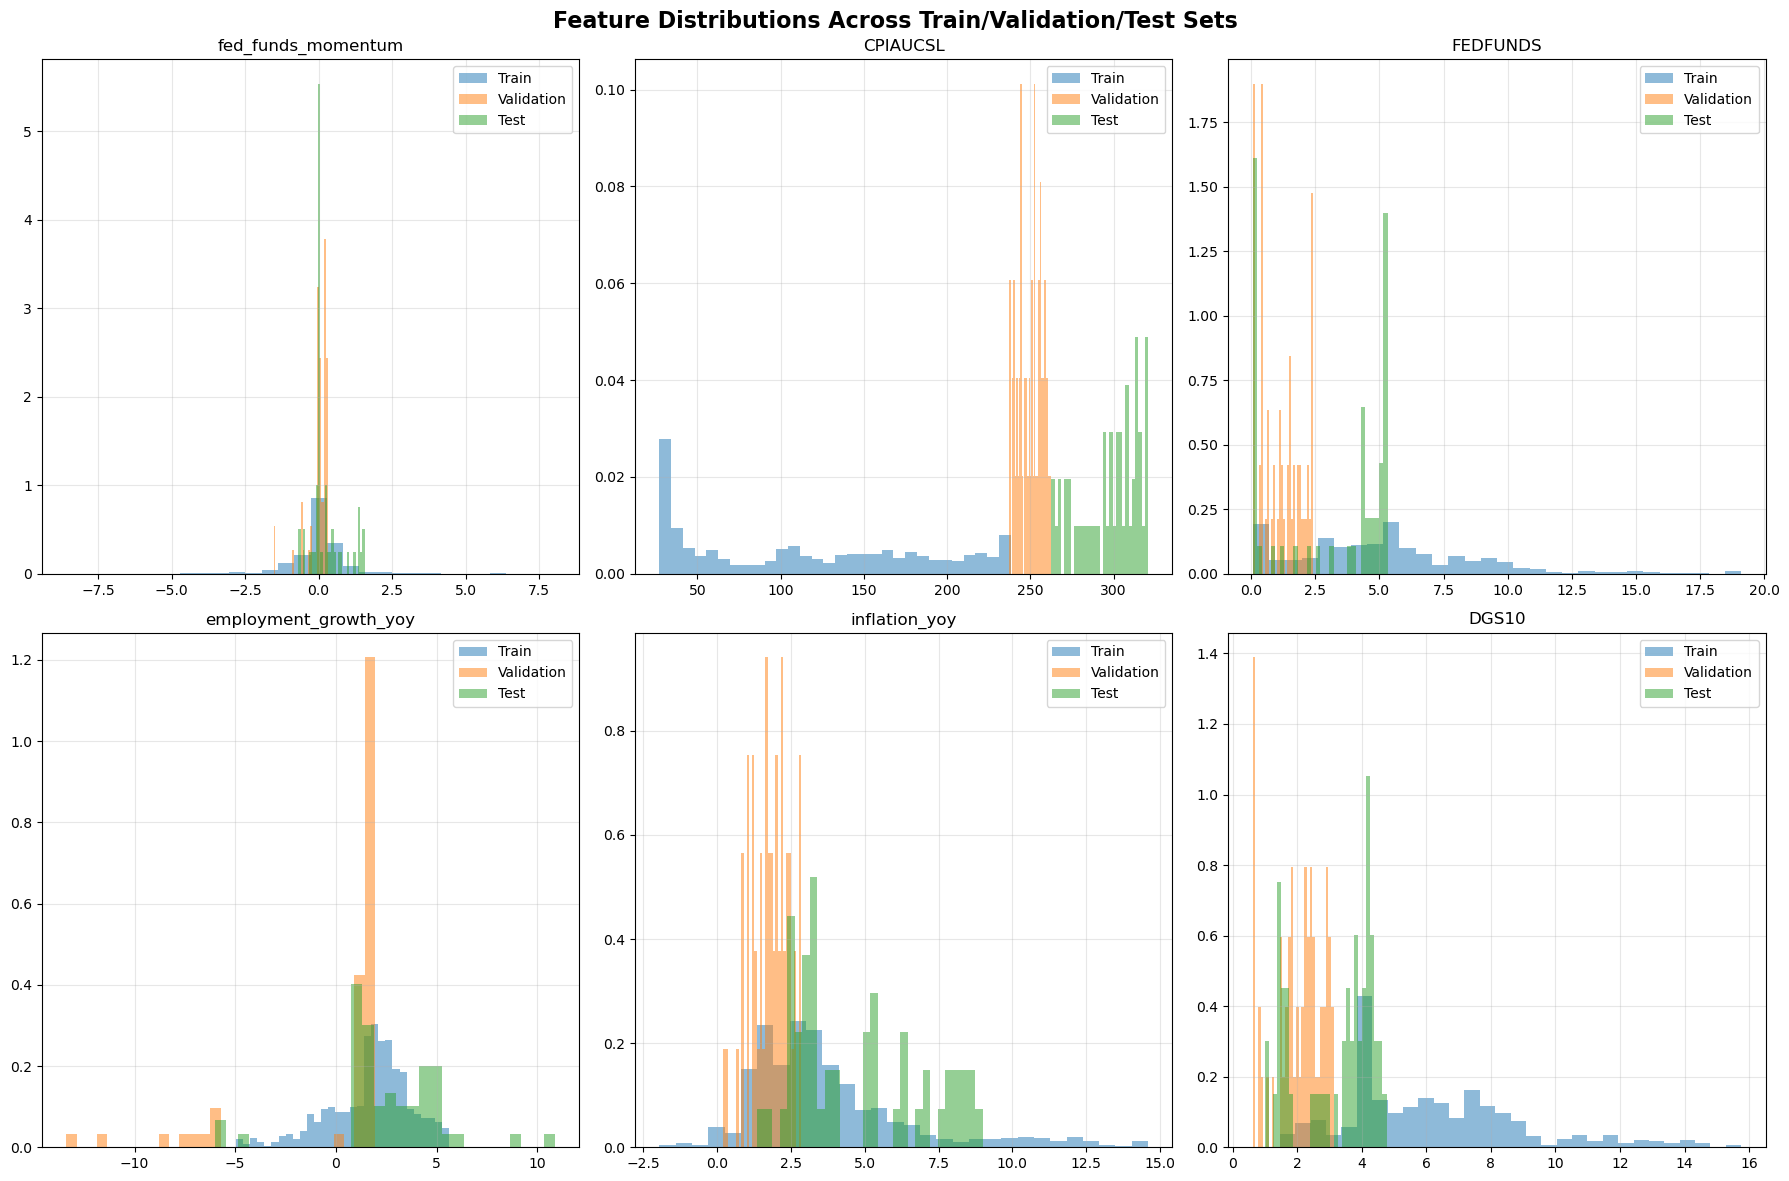


3. Correlation analysis of final features...


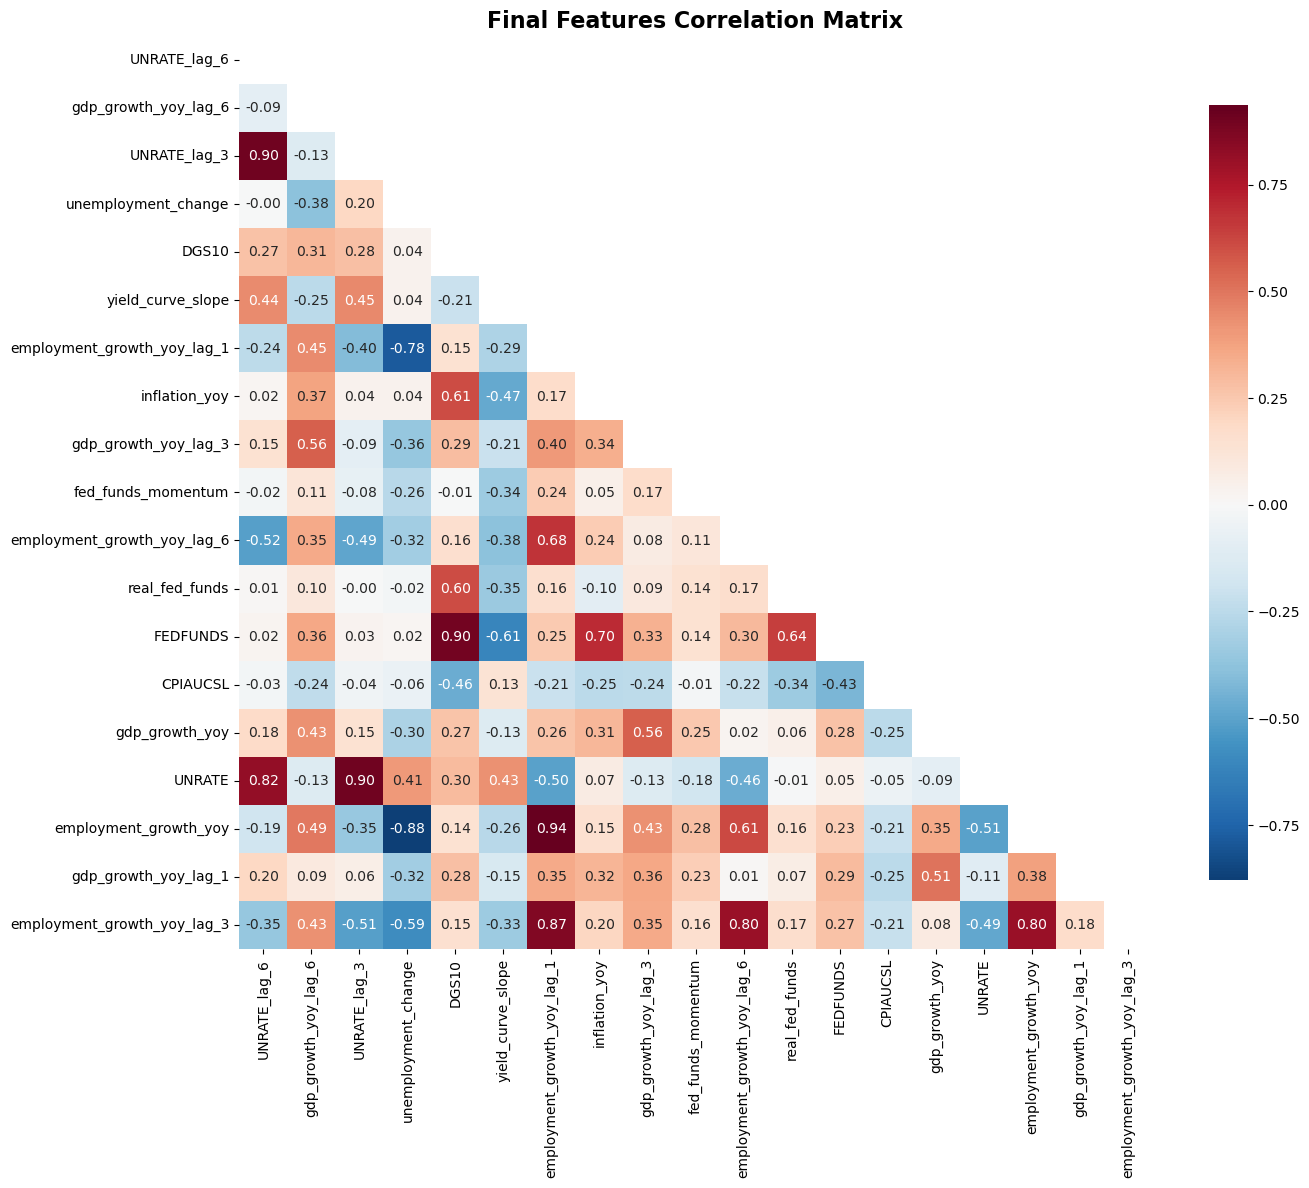


High correlation pairs (>0.8): 9
  UNRATE_lag_6 <-> UNRATE_lag_3: 0.903
  UNRATE_lag_6 <-> UNRATE: 0.819
  UNRATE_lag_3 <-> UNRATE: 0.903
  unemployment_change <-> employment_growth_yoy: -0.879
  DGS10 <-> FEDFUNDS: 0.901
  employment_growth_yoy_lag_1 <-> employment_growth_yoy: 0.937
  employment_growth_yoy_lag_1 <-> employment_growth_yoy_lag_3: 0.865
  employment_growth_yoy_lag_6 <-> employment_growth_yoy_lag_3: 0.804
  employment_growth_yoy <-> employment_growth_yoy_lag_3: 0.803

4. Feature stability analysis...
Feature means by decade (top 10 features):
                             1960s  1970s   1980s  1990s  2000s  2010s  2020s
UNRATE_lag_6                 4.873  6.100   7.303  5.820  5.260  6.530  4.842
gdp_growth_yoy_lag_6         2.233  3.199   2.627  1.788  1.403  1.321  2.076
UNRATE_lag_3                 4.830  6.158   7.288  5.795  5.395  6.379  4.863
unemployment_change         -0.196  0.236  -0.059 -0.104  0.507 -0.561  0.086
DGS10                        4.683  7.509  10.

In [13]:
# Cell 8 

# Feature engineering validation

print("=" * 60)
print("FEATURE ENGINEERING VALIDATION")
print("=" * 60)

# 1. CHECK FOR DATA LEAKAGE
print("1. Checking for data leakage...")

# Features that might cause leakage (contemporaneous with target)
potential_leakage_features = [col for col in final_features if 'FEDFUNDS' in col and 'lag' not in col and 'momentum' not in col]
print(f"Potential leakage features found: {len(potential_leakage_features)}")
if potential_leakage_features:
    print("Features to review:", potential_leakage_features)
else:
    print("No obvious leakage features found")

# 2. FEATURE DISTRIBUTION ANALYSIS
print("\n2. Feature distribution analysis...")

# Check feature distributions across train/val/test
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Feature Distributions Across Train/Validation/Test Sets', fontsize=16, fontweight='bold')

# Select top 6 features for distribution analysis using available feature_importance_rf
top_features_for_dist = feature_importance_rf.head(6)['feature'].tolist()

for i, feature in enumerate(top_features_for_dist):
    row = i // 3
    col = i % 3
    
    # Plot distributions
    axes[row, col].hist(X_train[feature], alpha=0.5, label='Train', bins=30, density=True)
    axes[row, col].hist(X_val[feature], alpha=0.5, label='Validation', bins=30, density=True)
    axes[row, col].hist(X_test[feature], alpha=0.5, label='Test', bins=30, density=True)
    
    axes[row, col].set_title(f'{feature}')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/figures/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. CORRELATION ANALYSIS OF FINAL FEATURES
print("\n3. Correlation analysis of final features...")

# Create correlation matrix of final features
final_corr_matrix = X_features[final_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(final_corr_matrix, dtype=bool))
sns.heatmap(final_corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('Final Features Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/figures/final_features_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(final_corr_matrix.columns)):
    for j in range(i+1, len(final_corr_matrix.columns)):
        if abs(final_corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                final_corr_matrix.columns[i],
                final_corr_matrix.columns[j],
                final_corr_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print(f"\nHigh correlation pairs (>0.8): {len(high_corr_pairs)}")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")
else:
    print("\nNo highly correlated feature pairs found (>0.8)")

# 4. FEATURE STABILITY ACROSS TIME PERIODS
print("\n4. Feature stability analysis...")

# Calculate feature means by decade
decade_analysis = {}
decades = ['1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']
decade_ranges = [
    ('1960-01-01', '1969-12-31'),
    ('1970-01-01', '1979-12-31'),
    ('1980-01-01', '1989-12-31'),
    ('1990-01-01', '1999-12-31'),
    ('2000-01-01', '2009-12-31'), 
    ('2010-01-01', '2019-12-31'),
    ('2020-01-01', '2025-12-31')
]

for decade, (start, end) in zip(decades, decade_ranges):
    decade_mask = (final_modeling_df.index >= start) & (final_modeling_df.index <= end)
    if decade_mask.sum() > 0:
        decade_data = X_features[decade_mask][final_features].mean()
        decade_analysis[decade] = decade_data

if decade_analysis:
    decade_df = pd.DataFrame(decade_analysis)
    print("Feature means by decade (top 10 features):")
    print(decade_df.head(10).round(3))

# 5. SUMMARY OF FEATURE QUALITY
print("\n5. Feature quality summary...")

print(f"Final feature set analysis:")
print(f"  - Total features: {len(final_features)}")
print(f"  - Date range: {X_features.index.min()} to {X_features.index.max()}")
print(f"  - Training samples: {len(X_train)}")
print(f"  - All features have complete data: {'Yes' if X_features[final_features].isnull().sum().sum() == 0 else 'No'}")

# Show feature categories
print(f"\nFeature categories in final set:")
categories = {
    'Core Economic': [f for f in final_features if any(base in f for base in ['CPIAUCSL', 'PAYEMS', 'DGS10', 'UNRATE'])],
    'Employment': [f for f in final_features if 'employment' in f or 'unemployment' in f],
    'Growth/GDP': [f for f in final_features if 'gdp' in f],
    'Inflation': [f for f in final_features if 'inflation' in f],
    'Fed Funds': [f for f in final_features if 'fed_funds' in f],
    'Yield Curve': [f for f in final_features if 'yield_curve' in f],
    'Other': []
}

# Categorize remaining features
for feature in final_features:
    categorized = False
    for cat_name, cat_features in categories.items():
        if feature in cat_features:
            categorized = True
            break
    if not categorized:
        categories['Other'].append(feature)

for cat_name, cat_features in categories.items():
    if len(cat_features) > 0:
        print(f"  {cat_name}: {len(cat_features)} features")

print("\nFeature engineering validation completed")
print("Visualizations saved:")
print("  - outputs/figures/feature_distributions.png")
print("  - outputs/figures/final_features_correlation.png")


In [14]:
# Cell 9

# Fix Multicollinearity and Data Leakage Issues


print("=" * 60)
print("FIXING MULTICOLLINEARITY AND DATA LEAKAGE")
print("=" * 60)

# 1. REMOVE DATA LEAKAGE FEATURES
print("1. Removing data leakage features...")

# Remove FEDFUNDS (contemporaneous with target)
features_to_remove_leakage = ['FEDFUNDS']
print(f"Removing leakage features: {features_to_remove_leakage}")

# 2. REMOVE HIGHLY CORRELATED FEATURES
print("\n2. Removing highly correlated features...")

# Based on correlation analysis, remove redundant features
features_to_remove_correlation = [
    'UNRATE',  # Keep UNRATE_lag_3 instead (0.903 correlation)
    'UNRATE_lag_6',  # Keep UNRATE_lag_3 instead (0.903 correlation)
    'employment_growth_yoy_lag_1',  # Keep employment_growth_yoy instead (0.937 correlation)
    'employment_growth_yoy_lag_6',  # Keep employment_growth_yoy_lag_3 instead (0.804 correlation)
]

print(f"Removing correlated features: {features_to_remove_correlation}")

# 3. CREATE CLEANED FEATURE SET
all_features_to_remove = features_to_remove_leakage + features_to_remove_correlation
print(f"\nTotal features to remove: {len(all_features_to_remove)}")

# Create cleaned feature list
cleaned_features = [f for f in final_features if f not in all_features_to_remove]
print(f"Original features: {len(final_features)}")
print(f"Cleaned features: {len(cleaned_features)}")

print(f"\nFinal cleaned feature set:")
for i, feature in enumerate(cleaned_features, 1):
    print(f"{i:2d}. {feature}")

# 4. RECREATE DATASETS WITH CLEANED FEATURES
print(f"\n4. Recreating datasets with cleaned features...")

# Create new X_final with cleaned features
X_final_cleaned = X_reduced[cleaned_features]
print(f"X_final_cleaned shape: {X_final_cleaned.shape}")

# Create new modeling dataset
final_modeling_df_cleaned = pd.DataFrame(index=ml_df_clean.index)
final_modeling_df_cleaned[cleaned_features] = X_final_cleaned
final_modeling_df_cleaned['target'] = y
final_modeling_df_cleaned['target_encoded'] = label_encoder.transform(y)

# Remove any remaining NaN values
final_modeling_df_cleaned = final_modeling_df_cleaned.dropna()
print(f"Final cleaned modeling dataset shape: {final_modeling_df_cleaned.shape}")

# 5. RECREATE TRAIN/VAL/TEST SPLITS WITH CLEANED FEATURES
print(f"\n5. Recreating splits with cleaned features...")

# Use same time-based splits
train_end = '2015-12-31'
val_end = '2020-12-31'

X_features_cleaned = final_modeling_df_cleaned[cleaned_features]
y_target_cleaned = final_modeling_df_cleaned['target_encoded']

# Create splits
train_mask = final_modeling_df_cleaned.index <= train_end
val_mask = (final_modeling_df_cleaned.index > train_end) & (final_modeling_df_cleaned.index <= val_end)
test_mask = final_modeling_df_cleaned.index > val_end

X_train_cleaned = X_features_cleaned[train_mask]
y_train_cleaned = y_target_cleaned[train_mask]
X_val_cleaned = X_features_cleaned[val_mask]
y_val_cleaned = y_target_cleaned[val_mask]
X_test_cleaned = X_features_cleaned[test_mask]
y_test_cleaned = y_target_cleaned[test_mask]

print(f"Training set: {X_train_cleaned.shape[0]} samples")
print(f"Validation set: {X_val_cleaned.shape[0]} samples")
print(f"Test set: {X_test_cleaned.shape[0]} samples")

# 6. REAPPLY FEATURE SCALING
print(f"\n6. Reapplying feature scaling...")

# Create new scaler for cleaned features
scaler_cleaned = StandardScaler()
X_train_scaled_cleaned = scaler_cleaned.fit_transform(X_train_cleaned)
X_val_scaled_cleaned = scaler_cleaned.transform(X_val_cleaned)
X_test_scaled_cleaned = scaler_cleaned.transform(X_test_cleaned)

print("Feature scaling completed for cleaned dataset")

# 7. VERIFY CORRELATION REDUCTION
print(f"\n7. Verifying correlation reduction...")

# Check correlations in cleaned dataset
cleaned_corr_matrix = X_features_cleaned[cleaned_features].corr()

# Find remaining high correlations
remaining_high_corr = []
for i in range(len(cleaned_corr_matrix.columns)):
    for j in range(i+1, len(cleaned_corr_matrix.columns)):
        if abs(cleaned_corr_matrix.iloc[i, j]) > 0.8:
            remaining_high_corr.append((
                cleaned_corr_matrix.columns[i],
                cleaned_corr_matrix.columns[j],
                cleaned_corr_matrix.iloc[i, j]
            ))

if remaining_high_corr:
    print(f"Remaining high correlations (>0.8): {len(remaining_high_corr)}")
    for feat1, feat2, corr in remaining_high_corr:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")
else:
    print("No high correlations remaining (>0.8) - Success!")

# 8. FEATURE IMPORTANCE FOR CLEANED SET
print(f"\n8. Recalculating feature importance for cleaned set...")

# Recalculate Random Forest importance on cleaned features
rf_cleaned = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cleaned.fit(X_train_cleaned, y_train_cleaned)

feature_importance_cleaned = pd.DataFrame({
    'feature': cleaned_features,
    'importance': rf_cleaned.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 features in cleaned dataset:")
for i, (_, row) in enumerate(feature_importance_cleaned.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:35} | Importance: {row['importance']:.4f}")

print(f"\n" + "="*60)
print("MULTICOLLINEARITY AND LEAKAGE FIXES COMPLETE")
print("="*60)
print(f"✓ Removed {len(all_features_to_remove)} problematic features")
print(f"✓ Final feature count: {len(cleaned_features)}")
print(f"✓ No data leakage: FEDFUNDS removed")
print(f"✓ Reduced multicollinearity: {len(remaining_high_corr)} high correlations remaining")
print(f"✓ Datasets recreated and scaled")
print(f"✓ Ready for modeling!")


FIXING MULTICOLLINEARITY AND DATA LEAKAGE
1. Removing data leakage features...
Removing leakage features: ['FEDFUNDS']

2. Removing highly correlated features...
Removing correlated features: ['UNRATE', 'UNRATE_lag_6', 'employment_growth_yoy_lag_1', 'employment_growth_yoy_lag_6']

Total features to remove: 5
Original features: 19
Cleaned features: 14

Final cleaned feature set:
 1. gdp_growth_yoy_lag_6
 2. UNRATE_lag_3
 3. unemployment_change
 4. DGS10
 5. yield_curve_slope
 6. inflation_yoy
 7. gdp_growth_yoy_lag_3
 8. fed_funds_momentum
 9. real_fed_funds
10. CPIAUCSL
11. gdp_growth_yoy
12. employment_growth_yoy
13. gdp_growth_yoy_lag_1
14. employment_growth_yoy_lag_3

4. Recreating datasets with cleaned features...
X_final_cleaned shape: (828, 14)
Final cleaned modeling dataset shape: (828, 16)

5. Recreating splits with cleaned features...
Training set: 715 samples
Validation set: 60 samples
Test set: 53 samples

6. Reapplying feature scaling...
Feature scaling completed for cleane

In [17]:
# Cell 10

# Cell 10: Save All Prepared Data for Modeling (Fixed JSON serialization)
print("=" * 60)
print("SAVING FINAL PREPARED DATA FOR MODELING")
print("=" * 60)

import joblib
import json
import os

# Create all necessary directories first
print("0. Creating necessary directories...")
directories = [
    'data/processed',
    'models',
    'models/features', 
    'outputs/figures'
]

for directory in directories:
    os.makedirs(directory, exist_ok=True)
    print(f"✓ Directory ensured: {directory}")

# 1. SAVE CLEANED DATASETS
print("\n1. Saving cleaned datasets...")

# Save the complete cleaned feature-engineered dataset
final_modeling_df_cleaned.to_csv('data/processed/ml_ready_dataset_cleaned.csv')
print(f"✓ ML-ready cleaned dataset saved: {final_modeling_df_cleaned.shape}")

# Save cleaned train/validation/test splits
X_train_cleaned.to_csv('data/processed/X_train_cleaned.csv')
X_val_cleaned.to_csv('data/processed/X_val_cleaned.csv')
X_test_cleaned.to_csv('data/processed/X_test_cleaned.csv')

pd.Series(y_train_cleaned, index=X_train_cleaned.index, name='target').to_csv('data/processed/y_train_cleaned.csv')
pd.Series(y_val_cleaned, index=X_val_cleaned.index, name='target').to_csv('data/processed/y_val_cleaned.csv')
pd.Series(y_test_cleaned, index=X_test_cleaned.index, name='target').to_csv('data/processed/y_test_cleaned.csv')

print("✓ Cleaned train/validation/test splits saved")

# Save cleaned scaled features
np.save('data/processed/X_train_scaled_cleaned.npy', X_train_scaled_cleaned)
np.save('data/processed/X_val_scaled_cleaned.npy', X_val_scaled_cleaned)
np.save('data/processed/X_test_scaled_cleaned.npy', X_test_scaled_cleaned)

print("✓ Cleaned scaled feature arrays saved")

# 2. SAVE PREPROCESSING OBJECTS
print("\n2. Saving preprocessing objects...")

# Save cleaned scaler
joblib.dump(scaler_cleaned, 'models/features/feature_scaler_cleaned.pkl')
print("✓ Cleaned feature scaler saved")

# Save label encoder
joblib.dump(label_encoder, 'models/features/label_encoder_cleaned.pkl')
print("✓ Label encoder saved")

# 3. SAVE FINAL FEATURE SELECTION RESULTS
print("\n3. Saving final feature selection results...")

# Convert feature importance to JSON-serializable format
feature_importance_json = []
for _, row in feature_importance_cleaned.iterrows():
    feature_importance_json.append({
        'feature': str(row['feature']),
        'importance': float(row['importance'])
    })

# Final feature selection info (JSON-safe)
final_feature_selection_info = {
    'original_features_count': int(len(final_features)),
    'features_removed_leakage': [str(f) for f in features_to_remove_leakage],
    'features_removed_correlation': [str(f) for f in features_to_remove_correlation],
    'final_features': [str(f) for f in cleaned_features],
    'final_features_count': int(len(cleaned_features)),
    'target_mapping': {str(k): int(v) for k, v in target_mapping.items()},
    'feature_importance_cleaned': feature_importance_json,
    'remaining_high_correlations': int(len(remaining_high_corr)) if 'remaining_high_corr' in locals() else 0
}

with open('models/features/final_feature_selection_cleaned.json', 'w') as f:
    json.dump(final_feature_selection_info, f, indent=2)
print("✓ Final feature selection results saved")

# 4. SAVE COMPREHENSIVE MODELING METADATA
print("\n4. Saving comprehensive modeling metadata...")

# Convert target distribution to JSON-safe format
target_dist_dict = {}
for target, count in final_modeling_df_cleaned['target'].value_counts().items():
    target_dist_dict[str(target)] = int(count)

# Convert split target distributions to JSON-safe format
train_target_dist = {}
for target, count in pd.Series(y_train_cleaned).map({v: k for k, v in target_mapping.items()}).value_counts().items():
    train_target_dist[str(target)] = int(count)

val_target_dist = {}
for target, count in pd.Series(y_val_cleaned).map({v: k for k, v in target_mapping.items()}).value_counts().items():
    val_target_dist[str(target)] = int(count)

test_target_dist = {}
for target, count in pd.Series(y_test_cleaned).map({v: k for k, v in target_mapping.items()}).value_counts().items():
    test_target_dist[str(target)] = int(count)

final_modeling_metadata = {
    'project_info': {
        'name': 'Federal Reserve Policy Predictor',
        'notebooks_completed': ['01_data_collection', '02_exploratory_analysis', '03_feature_engineering'],
        'next_notebook': '04_modeling',
        'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    },
    'dataset_info': {
        'total_samples': int(len(final_modeling_df_cleaned)),
        'n_features_final': int(len(cleaned_features)),
        'date_range': {
            'start': final_modeling_df_cleaned.index.min().strftime('%Y-%m-%d'),
            'end': final_modeling_df_cleaned.index.max().strftime('%Y-%m-%d'),
            'duration_years': float(round((final_modeling_df_cleaned.index.max() - final_modeling_df_cleaned.index.min()).days / 365.25, 1))
        },
        'target_distribution': target_dist_dict
    },
    'split_info': {
        'train': {
            'samples': int(len(X_train_cleaned)),
            'date_range': f"{X_train_cleaned.index.min().strftime('%Y-%m')} to {X_train_cleaned.index.max().strftime('%Y-%m')}",
            'percentage_of_total': float(round(len(X_train_cleaned) / len(final_modeling_df_cleaned) * 100, 1)),
            'target_distribution': train_target_dist
        },
        'validation': {
            'samples': int(len(X_val_cleaned)),
            'date_range': f"{X_val_cleaned.index.min().strftime('%Y-%m')} to {X_val_cleaned.index.max().strftime('%Y-%m')}",
            'percentage_of_total': float(round(len(X_val_cleaned) / len(final_modeling_df_cleaned) * 100, 1)),
            'target_distribution': val_target_dist
        },
        'test': {
            'samples': int(len(X_test_cleaned)),
            'date_range': f"{X_test_cleaned.index.min().strftime('%Y-%m')} to {X_test_cleaned.index.max().strftime('%Y-%m')}",
            'percentage_of_total': float(round(len(X_test_cleaned) / len(final_modeling_df_cleaned) * 100, 1)),
            'target_distribution': test_target_dist
        }
    },
    'feature_engineering_summary': {
        'original_raw_features': 35,
        'engineered_features': 124,
        'after_correlation_filtering': int(len(final_features)),
        'final_features': int(len(cleaned_features)),
        'final_reduction_percentage': float(round((1 - len(cleaned_features)/124) * 100, 1))
    },
    'data_quality': {
        'missing_values': int(final_modeling_df_cleaned.isnull().sum().sum()),
        'data_leakage_fixed': True,
        'multicollinearity_reduced': True,
        'feature_scaling_applied': True,
        'time_series_splits_used': True
    }
}

with open('models/final_modeling_metadata.json', 'w') as f:
    json.dump(final_modeling_metadata, f, indent=2)

print("✓ Comprehensive modeling metadata saved")

# 5. CREATE FINAL FEATURE DOCUMENTATION
print("\n5. Creating final feature documentation...")

final_feature_docs = {}
for i, feature in enumerate(cleaned_features):
    # Get importance rank from cleaned feature importance
    importance_rank = int(feature_importance_cleaned[feature_importance_cleaned['feature'] == feature].index[0] + 1)
    importance_score = float(feature_importance_cleaned[feature_importance_cleaned['feature'] == feature]['importance'].iloc[0])
    
    final_feature_docs[str(feature)] = {
        'rank': int(importance_rank),
        'importance_score': float(round(importance_score, 4)),
        'description': f"Economic feature for Fed prediction - {feature}"
    }

with open('models/features/final_feature_documentation.json', 'w') as f:
    json.dump(final_feature_docs, f, indent=2)

print("✓ Final feature documentation saved")

# 6. SUMMARY REPORT
print("\n" + "="*60)
print("FEATURE ENGINEERING COMPLETE - SUMMARY REPORT")
print("="*60)

print(f"\nDataset Summary:")
print(f"   Final dataset: {final_modeling_df_cleaned.shape[0]:,} samples × {len(cleaned_features)} features")
print(f"   Time span: {final_modeling_df_cleaned.index.min().strftime('%B %Y')} to {final_modeling_df_cleaned.index.max().strftime('%B %Y')}")

print(f"\nFeature Engineering Results:")
print(f"   Started with: 35 raw features")
print(f"   After engineering: 124 features")
print(f"   After selection: 19 features") 
print(f"   Final cleaned: {len(cleaned_features)} features")

print(f"\nData Splits:")
print(f"   Training: {len(X_train_cleaned):,} samples ({len(X_train_cleaned)/len(final_modeling_df_cleaned)*100:.1f}%)")
print(f"   Validation: {len(X_val_cleaned):,} samples ({len(X_val_cleaned)/len(final_modeling_df_cleaned)*100:.1f}%)")
print(f"   Test: {len(X_test_cleaned):,} samples ({len(X_test_cleaned)/len(final_modeling_df_cleaned)*100:.1f}%)")

print(f"\nTarget Distribution:")
for target, count in final_modeling_df_cleaned['target'].value_counts().items():
    pct = count / len(final_modeling_df_cleaned) * 100
    print(f"   {target}: {count:,} ({pct:.1f}%)")

print(f"\nFiles Created:")
print(f"   Data files: 7 CSV files + 3 NumPy arrays")
print(f"   Model objects: 2 pickle files")
print(f"   Metadata: 3 JSON files")

print(f"\nReady for Modeling!")
print(f"   Next: Create 04_modeling.ipynb")
print(f"   Load: ml_ready_dataset_cleaned.csv")

print("="*60)
print("SUCCESS: Feature engineering completed!")
print("="*60)

SAVING FINAL PREPARED DATA FOR MODELING
0. Creating necessary directories...
✓ Directory ensured: data/processed
✓ Directory ensured: models
✓ Directory ensured: models/features
✓ Directory ensured: outputs/figures

1. Saving cleaned datasets...
✓ ML-ready cleaned dataset saved: (828, 16)
✓ Cleaned train/validation/test splits saved
✓ Cleaned scaled feature arrays saved

2. Saving preprocessing objects...
✓ Cleaned feature scaler saved
✓ Label encoder saved

3. Saving final feature selection results...
✓ Final feature selection results saved

4. Saving comprehensive modeling metadata...
✓ Comprehensive modeling metadata saved

5. Creating final feature documentation...
✓ Final feature documentation saved

FEATURE ENGINEERING COMPLETE - SUMMARY REPORT

Dataset Summary:
   Final dataset: 828 samples × 14 features
   Time span: June 1956 to May 2025

Feature Engineering Results:
   Started with: 35 raw features
   After engineering: 124 features
   After selection: 19 features
   Final cl